In [4]:
import torch
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output
import numpy as np
import pylab as pl

from src import *

In [5]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 16    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
N_ITERS = 45           # Iterations before applying the loss
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5
VIRUS_PROPORTION = 0.1

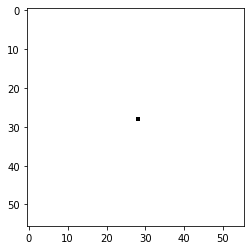

In [6]:
# Starting state
pool = SamplePool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
imshow(pool[0][0])

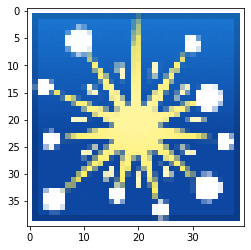

In [7]:
# Imports the target emoji
target = read_image("firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [9]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

In [10]:
# loads a pretrained model
old_CA = CAModel().to(device)
old_CA.load("firework_growing.pt")

Successfully loaded model!


In [11]:
new_CA = CAModel().to(device)
new_CA.load("Virus 60%.pt")
model = VirusCA(old_CA, new_CA)

Successfully loaded model!


In [20]:
# Train the model
torch.backends.cudnn.benchmark = True

for param in model.old_CA.parameters():
   param.requires_grad = False

optimizer = torch.optim.Adam(model.new_CA.parameters(), lr=2e-3)
criterion = NCALoss(pad(target, TARGET_PADDING), order=2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)
model.train_CA(optimizer, criterion, pool, n_epochs=300, scheduler=scheduler)

KeyboardInterrupt: 

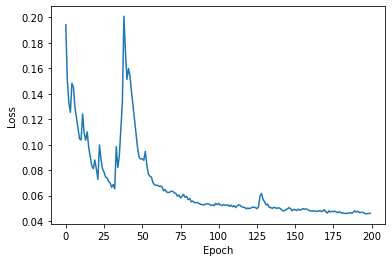

In [32]:
pl.plot(model.losses)
pl.xlabel("Epoch")
pl.ylabel("Loss")
pl.savefig(fname="Virus60%_losses.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


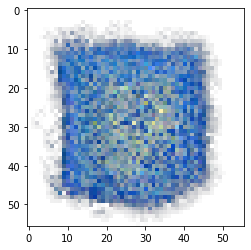

In [31]:
imshow(pool.sample(1)[0][0])

In [13]:
model.make_video(150, IMAGE_SIZE, "Virus.mkv")

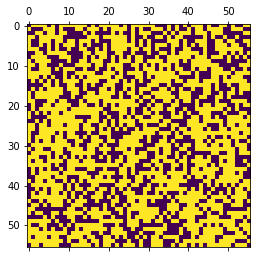

In [17]:
pl.matshow(model.new_cells.cpu()[0,0])
pl.savefig("Virus 60% cell mask.png", dpi=200)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


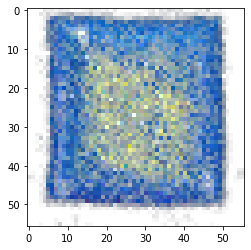

In [16]:
# Plots the learned CA
x, _ = pool.sample(1)
model.update_cell_masks(x)
x = x.to(device)
x = model.evolve(x, 1000)

imshow(x[0])

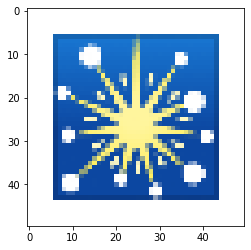

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))